# Чем лучше бустить? Тестируем алгоритмы бустинга в бою.

**Цель:** В этом домашнем задании вам предстоит провести детективную работу и узнать, какой же алгоритм бустинга работает лучше всего (конечно, применительно к конкретной задаче)

## Часть 1. EDA
- Выберите любой интересующий вас датасет по классификации или регрессии (можно взять из рекозитория https://archive.ics.uci.edu/ml/datasets.php, еще неплохие и востребованные на практике варианты - предсказание оттока пользователей https://www.kaggle.com/blastchar/telco-customer-churn или предсказание Customer Livetime Value (CLV или LTV) - https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data
- По выбранному датасету проведите EDA, познакомьтесь с признаками, посмотрите зависимости и т.д.

## Часть 2. Preprocessing & Feature Engineering
- Хотя цель этого задания - посмотреть на работу алгоритмов, тем не менее пропускать препроцессинг нельзя :)
- Так что переведите категориальные переменные в уникальные лейблы при помощи LabelEncoder, попробуйте добавить новые переменные и выкинуть лишние и, наконец, разбейте данные на train-test

## Часть 3. Who's the mightiest of them all?
- Постройте 4 варианта градиентного бустинга, используя значения гиперпараметров “из коробки”: реализация из sklearn, XGBoost, CatBoost, LightGBM
- Проверьте качество на отложенной выборке, кто пока лидирует?
- Теперь проведите настройку гиперпараметров моделей на кросс-валидации, можно настраивать только самые основные гиперпараметры - число итераций бустинга, max_features, subsample и т.д.
- Снова проверьте качество уже настроенных моделей, кто, в итоге победил?

## Критерии оценки
- EDA для выбранного датасета - 1 балл
- Preprocessing - 1 балл
- Построение моделей из коробки и проверка качества - 4 балла
- Настройка гиперпараметров моделей и проверка качества - 4 балла

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

import seaborn as sns              
%matplotlib inline
sns.set()
from subprocess import check_output

import warnings                                           
warnings.filterwarnings('ignore') 



In [2]:
def annot_plot(ax,w,h, df):                                   
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for p in ax.patches:
         ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='black', rotation=0, xytext=(0, 10),
         textcoords='offset points')             
def annot_plot_num(ax,w,h):                                    # function to add data to plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for p in ax.patches:
        ax.annotate('{0:.1f}'.format(p.get_height()), (p.get_x()+w, p.get_height()+h))

In [3]:
#суммарный датафрейм со всеми результатами


result_columns = ['name','Accuracy','Precision','Recall','F1-score','AUC']
result = pd.DataFrame([], columns=result_columns)




def add_result_value(result, name, y_expected, y_predicted, y_predicted_proba):
    accuracy = accuracy_score(y_predicted, y_expected)
    precision = precision_score(y_predicted, y_expected)
    recall = recall_score(y_predicted, y_expected)
    f1 = f1_score(y_predicted, y_expected)    
    auc = roc_auc_score(y_expected, y_predicted_proba)

    
    
    return pd.concat([result, pd.DataFrame([[name,accuracy,precision,recall,f1,auc]], columns=result_columns)])


# Пример добавление данных в итоговую таблицу
#result = pd.concat([result, pd.DataFrame([['Linear',1,1,1)]], columns=result_columns)])

In [4]:
data = pd.read_csv('WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

In [5]:
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


Посмотрим и предскажем будет ли покупатель отвечать на звонки отдела маркетинга

In [6]:
data.shape

(9134, 24)

In [7]:
data.Response = data.Response.apply(lambda X : 0 if X == 'No' else 1)

In [8]:
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,0,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,0,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,0,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,0,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,0,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


# EDA

In [9]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   int64  
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [10]:
data.isnull().sum()

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

In [11]:
data.describe()

,Customer Lifetime Value,Response,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,0.143201,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,0.350297,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,0.000000,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,0.000000,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,1.000000,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


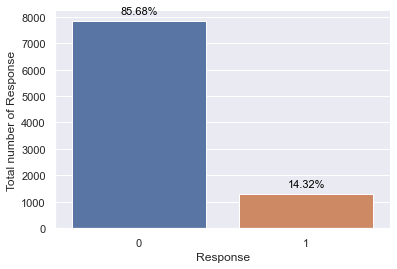

In [12]:
ax = sns.countplot('Response',data = data)
plt.ylabel('Total number of Response')
annot_plot(ax, 0.08,1, data)
plt.show()

Всего 14 процентов отвечают на звонки

#### Посмотрим как отвечают на звонки М и Ж

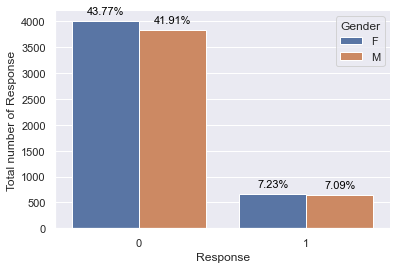

In [13]:
ax = sns.countplot('Response',hue = 'Gender' ,data = data)
plt.ylabel('Total number of Response')
annot_plot(ax, 0.08,1,data)
plt.show()

#### Посмотрим как ведут себя в зависимости от семейного положения

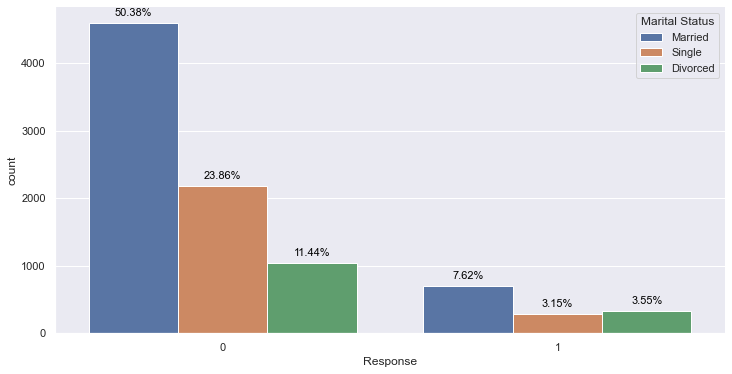

In [14]:
plt.figure(figsize=(12,6))
ax = sns.countplot('Response', hue = data['Marital Status'], data = data)
annot_plot(ax,0.08,1,data)
plt.show()

In [15]:
data['Marital Status'].value_counts()

Married     5298
Single      2467
Divorced    1369
Name: Marital Status, dtype: int64

Но как мы видим женатых в данной выборке большенство

#### По предложению

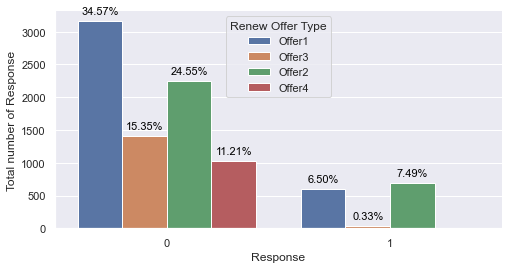

In [16]:
plt.figure(figsize=(8,4))
ax = sns.countplot('Response',hue = 'Renew Offer Type' ,data = data)
plt.ylabel('Total number of Response')
annot_plot(ax, 0.08,1,data)
plt.show()

#### По образованию

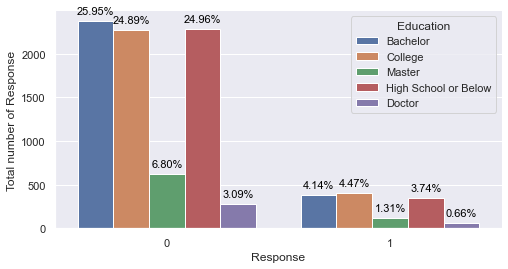

In [17]:
plt.figure(figsize=(8,4))
ax = sns.countplot('Response',hue = 'Education' ,data = data)
plt.ylabel('Total number of Response')
annot_plot(ax, 0.08,1,data)
plt.show()

#### По каналу продаж

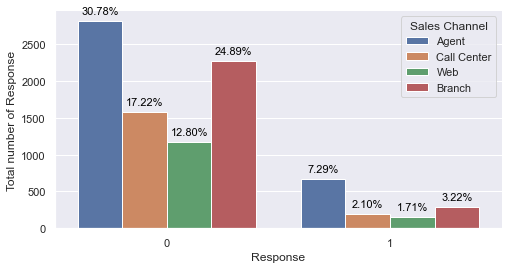

In [18]:
plt.figure(figsize=(8,4))
ax = sns.countplot('Response',hue = 'Sales Channel' ,data = data)
plt.ylabel('Total number of Response')
annot_plot(ax, 0.08,1,data)
plt.show()

#### По общей сумме

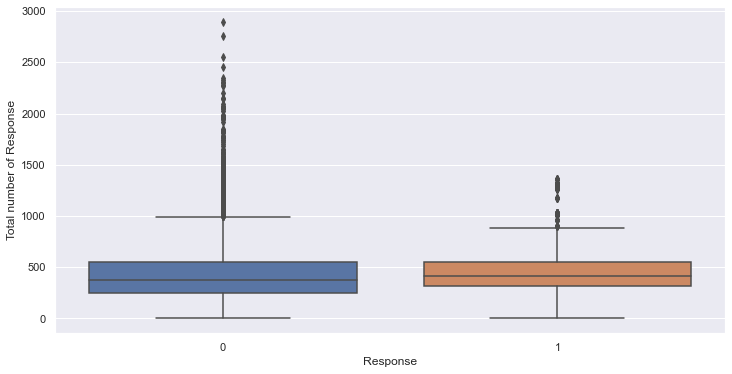

In [19]:
plt.figure(figsize=(12,6))
sns.boxplot(y = 'Total Claim Amount' , x = 'Response', data = data)
plt.ylabel('Total number of Response')
plt.show()

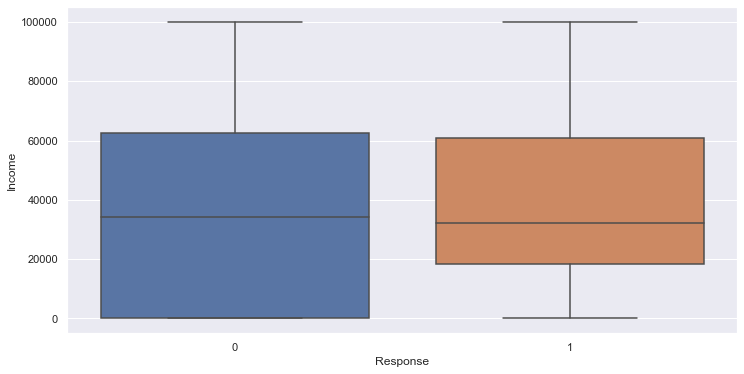

In [20]:
plt.figure(figsize=(12,6))
sns.boxplot(y = 'Income' , x = 'Response', data = data)
plt.show()

#### По занятости

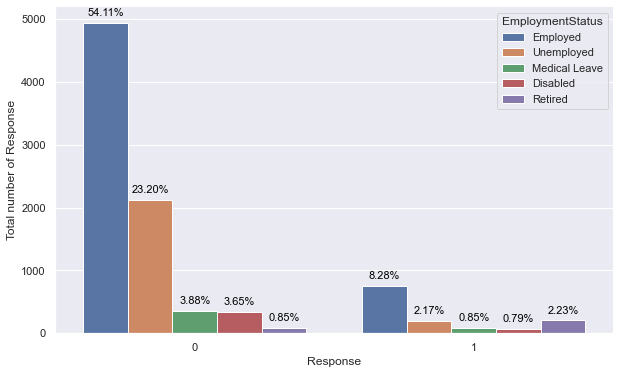

In [21]:
plt.figure(figsize=(10,6))
ax = sns.countplot('Response',hue = 'EmploymentStatus' ,data = data)
plt.ylabel('Total number of Response')
annot_plot(ax, 0.08,1,data)
plt.show()

#### По классу автомобиля

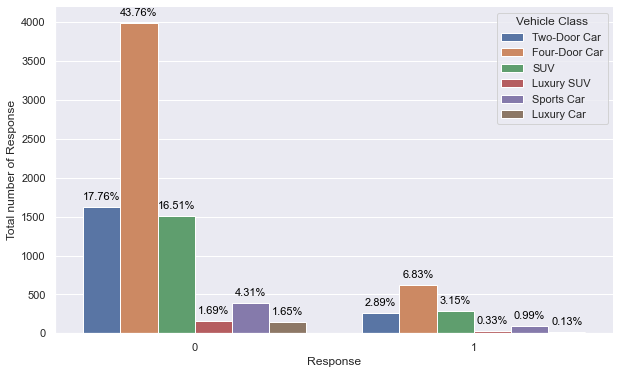

In [22]:
plt.figure(figsize=(10,6))
ax = sns.countplot('Response',hue = 'Vehicle Class' ,data = data)
plt.ylabel('Total number of Response')
annot_plot(ax, 0.08,1,data)
plt.show()

### Посмотрим 

In [23]:
continous_var_data = data.select_dtypes(include=['int64','float'])
continous_var_data.nunique()

Customer Lifetime Value          8041
Response                            2
Income                           5694
Monthly Premium Auto              202
Months Since Last Claim            36
Months Since Policy Inception     100
Number of Open Complaints           6
Number of Policies                  9
Total Claim Amount               5106
dtype: int64

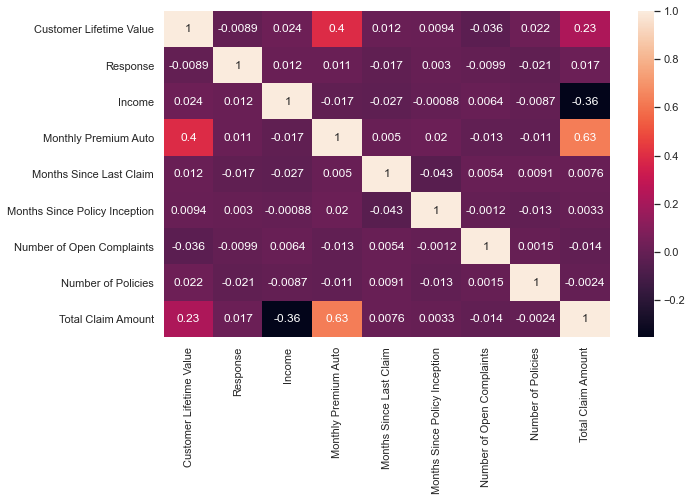

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(continous_var_data.corr(), annot = True)
plt.show()

In [25]:
categorical_data = data.select_dtypes(include='object')
cat_data = categorical_data.drop(['Customer','Effective To Date'], axis = 1)

In [26]:
cat_data.columns

Index(['State', 'Coverage', 'Education', 'EmploymentStatus', 'Gender',
       'Location Code', 'Marital Status', 'Policy Type', 'Policy',
       'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [27]:
cols = ['State', 'Coverage', 'Education', 'EmploymentStatus', 'Gender',
       'Location Code', 'Marital Status', 'Policy Type', 'Policy',
       'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size']

# Preprocessing & Feature Engineering

In [28]:
lb = LabelEncoder()
for col in cat_data[cols]:
    cat_data[col] = lb.fit_transform(cat_data[col])

In [29]:
cat_data.head()

,State,Coverage,Education,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
0,4,0,0,1,0,1,1,0,2,0,0,5,1
1,0,1,0,4,0,1,2,1,5,2,0,0,1
2,2,2,0,1,0,1,1,1,5,0,0,5,1
3,1,0,0,4,1,1,1,0,1,0,2,3,1
4,4,0,0,1,1,0,2,1,3,0,0,0,1


In [30]:
continous_var_data.reset_index(drop = True, inplace=True)
cat_data.reset_index(drop = True, inplace=True)

In [31]:
all_data = pd.concat([continous_var_data,cat_data], axis = 1)

In [32]:
all_data.head()

,Customer Lifetime Value,Response,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,...,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
0,2763.519279,0,56274,69,32,5,0,1,384.811147,4,...,1,0,1,1,0,2,0,0,5,1
1,6979.535903,0,0,94,13,42,0,8,1131.464935,0,...,4,0,1,2,1,5,2,0,0,1
2,12887.431650,0,48767,108,18,38,0,2,566.472247,2,...,1,0,1,1,1,5,0,0,5,1
3,7645.861827,0,0,106,18,65,0,7,529.881344,1,...,4,1,1,1,0,1,0,2,3,1
4,2813.692575,0,43836,73,12,44,0,1,138.130879,4,...,1,1,0,2,1,3,0,0,0,1


In [33]:
all_data.columns


Index(['Customer Lifetime Value', 'Response', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount',
       'State', 'Coverage', 'Education', 'EmploymentStatus', 'Gender',
       'Location Code', 'Marital Status', 'Policy Type', 'Policy',
       'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [34]:
X_train, X_test, y_train, y_test = train_test_split(all_data.drop('Response', axis=1), all_data['Response'], test_size=0.3, random_state=42)
TO_SCALE = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount',
       'State', 'Coverage', 'Education', 'EmploymentStatus', 'Gender',
       'Location Code', 'Marital Status', 'Policy Type', 'Policy',
       'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size']


X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler=StandardScaler()
scaler.fit(X_train[TO_SCALE])

X_train_scaled[TO_SCALE] = scaler.fit_transform(X_train[TO_SCALE])
X_test_scaled[TO_SCALE] = scaler.transform(X_test[TO_SCALE])



# Моделирование

## Градиентный бустинг


-GradientBoostingClassifier

-XGBClassifier

-CatBoostClassifier

-LGBMClassifier

###  Построение моделей градиентного бустинга без настройки гиперпараметров

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [36]:
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_scaled, y_train)
y_pred = gb_classifier.predict(X_test_scaled)
y_pred_proba = gb_classifier.predict_proba(X_test_scaled)

result = add_result_value(result,'GradientBoostingClassifier', y_test, y_pred, y_pred_proba[:, 1])

In [37]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train_scaled, y_train)
y_pred = xgb_classifier.predict(X_test_scaled)
y_pred_proba = xgb_classifier.predict_proba(X_test_scaled)
result = add_result_value(result,'XGBClassifier', y_test, y_pred, y_pred_proba[:, 1])

In [38]:
catboost_classifier = CatBoostClassifier(silent=True)
catboost_classifier.fit(X_train_scaled, y_train)
y_pred = catboost_classifier.predict(X_test_scaled)
y_pred_proba = catboost_classifier.predict_proba(X_test_scaled)
result = add_result_value(result,'CatBoostClassifier', y_test, y_pred, y_pred_proba[:, 1])

In [39]:
lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train_scaled, y_train)
y_pred = lgbm_classifier.predict(X_test_scaled)
y_pred_proba = lgbm_classifier.predict_proba(X_test_scaled)
result = add_result_value(result,'LGBMClassifier', y_test, y_pred, y_pred_proba[:, 1])

#### Смотрим результаты

In [40]:
result

,name,Accuracy,Precision,Recall,F1-score,AUC
0,GradientBoostingClassifier,0.877052,0.200489,0.891304,0.327345,0.916833
0,XGBClassifier,0.994163,0.992665,0.968974,0.980676,0.998871
0,CatBoostClassifier,0.983947,0.904645,0.986667,0.943878,0.996578
0,LGBMClassifier,0.981029,0.899756,0.970976,0.934010,0.997330


###  Построение моделей градиентного бустинга с настройкой гиперпараметров

In [41]:
%%time

parameters = {
    "n_estimators": stats.randint(10, 1000),
    "learning_rate": stats.uniform(0.01, 1),
    "subsample": stats.uniform(0.5, 1.0),

    "max_depth": stats.randint(3, 10),
    "min_samples_split": stats.randint(3, 20),
    "min_samples_leaf": stats.randint(3, 20)
}

gb_classifier_tuned = RandomizedSearchCV(GradientBoostingClassifier(), parameters, n_iter=100, cv=5, n_jobs=-1)
gb_classifier_tuned.fit(X_train_scaled, y_train)

print(gb_classifier_tuned.score(X_train_scaled, y_train))
print(gb_classifier_tuned.best_params_)

y_pred = gb_classifier_tuned.predict(X_test_scaled)
y_pred_proba = gb_classifier_tuned.predict_proba(X_test_scaled)
result = add_result_value(result,'GradientBoostingClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

1.0
{'learning_rate': 0.9626013537609057, 'max_depth': 8, 'min_samples_leaf': 16, 'min_samples_split': 12, 'n_estimators': 467, 'subsample': 0.9968954826709981}
CPU times: user 13.3 s, sys: 628 ms, total: 13.9 s
Wall time: 3min 14s


In [42]:
%%time

parameters = {
    'n_estimators': stats.randint(10, 1000),
    'learning_rate': stats.uniform(0.01, 1),
    'subsample': stats.uniform(0.5, 1.0),

    'max_depth': stats.randint(3, 10),
    'gamma': stats.uniform (1, 9),
    'min_child_weight' : stats.randint(0, 10),
    'colsample_bytree': stats.uniform(0.5, 1),
    'reg_alpha': stats.randint(0, 1),
    'reg_lambda': stats.uniform(0, 1),
}

xgb_classifier_tuned = RandomizedSearchCV(xgb.XGBClassifier(), parameters, n_iter=100, cv=5, n_jobs=-1)
xgb_classifier_tuned.fit(X_train_scaled, y_train)

print(xgb_classifier_tuned.score(X_train_scaled, y_train))
print(xgb_classifier_tuned.best_params_)


y_pred = xgb_classifier_tuned.predict(X_test_scaled)
y_pred_proba = xgb_classifier_tuned.predict_proba(X_test_scaled)
result = add_result_value(result, 'XGBClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

1.0
{'colsample_bytree': 0.720088099602206, 'gamma': 1.1716578797175938, 'learning_rate': 0.8826464008055853, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 396, 'reg_alpha': 0, 'reg_lambda': 0.7884969200856263, 'subsample': 0.9287283696467836}
CPU times: user 12.9 s, sys: 246 ms, total: 13.1 s
Wall time: 44.7 s


In [43]:
%%time

parameters = {
    'n_estimators': stats.randint(100, 1000),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.9),

    'depth': stats.randint(3, 13),
    "min_data_in_leaf": stats.randint(1, 10),    
    'l2_leaf_reg': stats.randint(1, 5),
    'random_strength': stats.uniform(0, 3),
    'bagging_temperature': stats.uniform(0.5, 1.0),
    'border_count': [32, 64, 128, 256]
}

catboost_classifier_tuned = RandomizedSearchCV(CatBoostClassifier(silent=True), parameters, 
                                               cv=5, n_jobs=-1)
catboost_classifier_tuned.fit(X_train_scaled, y_train)

print(catboost_classifier_tuned.score(X_train_scaled, y_train))
print(catboost_classifier_tuned.best_params_)

y_pred = catboost_classifier_tuned.predict(X_test_scaled)
y_pred_proba = catboost_classifier_tuned.predict_proba(X_test_scaled)
result = add_result_value(result, 'CatBoostClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

1.0
{'bagging_temperature': 0.9973364401764319, 'border_count': 32, 'depth': 9, 'l2_leaf_reg': 4, 'learning_rate': 0.05138742250310902, 'min_data_in_leaf': 4, 'n_estimators': 841, 'random_strength': 0.900795035641242, 'subsample': 0.757695578436046}
CPU times: user 37.3 s, sys: 1.2 s, total: 38.5 s
Wall time: 1min 55s


In [44]:
%%time

parameters = {
    "n_estimators": stats.randint(10, 100),
    "learning_rate": stats.uniform(0.01, 1),
    "subsample": stats.uniform(0.5, 1.0),
    
    "max_depth": stats.randint(3, 13),
    "num_leaves": stats.randint(1, 50),
    "min_data_in_leaf": stats.randint(1, 100),    
    "max_bin": stats.randint(3, 50),    
    "boosting_type" : ['gbdt', 'dart'],    
    'reg_alpha': stats.randint(0, 4),
    'reg_lambda': stats.uniform(0, 4)
}

lgbm_classifier_tuned = RandomizedSearchCV(LGBMClassifier(), parameters, n_iter=1000,
                                            scoring='accuracy', cv=5, n_jobs=-1)
lgbm_classifier_tuned.fit(X_train_scaled, y_train)

print(lgbm_classifier_tuned.score(X_train_scaled, y_train))
print(lgbm_classifier_tuned.best_params_)



y_pred = lgbm_classifier_tuned.predict(X_test_scaled)
y_pred_proba = lgbm_classifier_tuned.predict_proba(X_test_scaled)
result = add_result_value(result,'LGBMClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

1.0
{'boosting_type': 'gbdt', 'learning_rate': 0.5006164275624193, 'max_bin': 42, 'max_depth': 8, 'min_data_in_leaf': 1, 'n_estimators': 48, 'num_leaves': 30, 'reg_alpha': 0, 'reg_lambda': 0.09599269160941626, 'subsample': 0.5137333342885462}
CPU times: user 6.85 s, sys: 519 ms, total: 7.36 s
Wall time: 26.3 s


# Итоги

In [45]:
result

,name,Accuracy,Precision,Recall,F1-score,AUC
0,GradientBoostingClassifier,0.877052,0.200489,0.891304,0.327345,0.916833
0,XGBClassifier,0.994163,0.992665,0.968974,0.980676,0.998871
0,CatBoostClassifier,0.983947,0.904645,0.986667,0.943878,0.996578
0,LGBMClassifier,0.981029,0.899756,0.970976,0.934010,0.997330
0,GradientBoostingClassifier_Tuned,0.999635,1.000000,0.997561,0.998779,1.000000
0,XGBClassifier_Tuned,0.987961,1.000000,0.925339,0.961222,0.997762
0,CatBoostClassifier_Tuned,0.998541,1.000000,0.990315,0.995134,0.999990
0,LGBMClassifier_Tuned,0.989785,0.987775,0.946136,0.966507,0.999476
